In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
import xarray
import numpy
from matplotlib import pyplot
from e3smplot.e3sm_utils import open_dataset, get_data, get_area_weights, area_average, can_retrieve_field

In [3]:
# Compute a cloud mask based on a threshold of liquid and ice water content
def get_liq_cloud_mask(ds, threshold=1e-5):
    cldliq = get_data(ds, 'CLDLIQ')
    cld_mask = (cldliq > threshold) #(cldliq > threshold)
    cld_mask.attrs = {
        'long_name': 'Liquid cloud mask',
        'units': 'none',
        'description': f'CLDLIQ > {threshold}',
    }
    return cld_mask

def get_ice_cloud_mask(ds, threshold=1e-5):
    cldice = get_data(ds, 'CLDICE')
    cld_mask = (cldice > threshold) #(cldice > threshold)
    cld_mask.attrs = {
        'long_name': 'Ice cloud mask',
        'units': 'none',
        'description': f'CLDICE > {threshold}',
    }
    return cld_mask

def get_cloud_mask(ds):
    liq_mask = get_liq_cloud_mask(ds)
    ice_mask = get_ice_cloud_mask(ds)
    cld_mask = (liq_mask + ice_mask) > 0 #((liq_mask > 0) | (ice_mask > 0))
    cld_mask.attrs = {
        'long_name': 'Cloud mask',
        'units': 'none',
        'description': f'{liq_mask.attrs["description"]} | {ice_mask.attrs["description"]}',
    }
    return cld_mask

# Vertically-projected cloud area (shadow)
def get_liq_cloud_area(ds):
    # First get 3D cloud mask
    cld_mask = get_liq_cloud_mask(ds)
    # Project down
    cld_area = (cld_mask > 0).any(dim='lev')
    cld_area.attrs = {
        'long_name': 'Liquid cloud area mask',
        'units': 'none',
        'description': 'any(cld_mask > 0)',
    }
    return cld_area
# Vertically-projected cloud area (shadow)
def get_ice_cloud_area(ds):
    # First get 3D cloud mask
    cld_mask = get_ice_cloud_mask(ds)
    # Project down
    cld_area = (cld_mask > 0).any(dim='lev')
    cld_area.attrs = {
        'long_name': 'Ice cloud area mask',
        'units': 'none',
        'description': 'any(cld_mask > 0)',
    }
    return cld_area

# Vertically-projected cloud area (shadow)
def get_cloud_area(ds):
    # First get 3D cloud mask
    cld_mask = get_cloud_mask(ds)
    # Project down
    cld_area = (cld_mask > 0).any(dim='lev')
    cld_area.attrs = {
        'long_name': 'Cloud area mask',
        'units': 'none',
        'description': 'any(cld_mask > 0)',
    }
    return cld_area

CLDTOT
  find files...
  load dataset...
  get data...
  compute averages...
  convert units...
  plot...
LIQ_MASK
  find files...
  load dataset...
  get data...
  compute averages...
  convert units...
  plot...
ICE_MASK
  find files...
  load dataset...
  get data...
  compute averages...
  convert units...
  plot...
CLD_MASK
  find files...
  load dataset...
  get data...
  compute averages...
  convert units...
  plot...


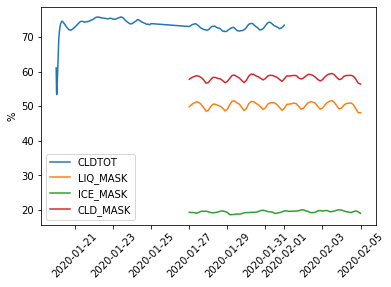

In [6]:
import sys
# Compare time series of CLDTOT, LIQ_MASK, ICE_MASK, CLD_MASK
variable_names = ('CLDTOT', 'LIQ_MASK', 'ICE_MASK', 'CLD_MASK')
output_path = '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127'
all_files = glob(f'{output_path}/*.eam.h[0-9].*.nc')
figure, ax = pyplot.subplots(1, 1) # figsize=(10, 10))

for ivar, v in enumerate(variable_names):
    # find files
    print(v)
    print('  find files...'); sys.stdout.flush()
    these_files = [f for f in all_files if can_retrieve_field(f, v)]
    
    # Load files
    print('  load dataset...'); sys.stdout.flush()
    ds = open_dataset(sorted(these_files), chunks={'time': 1, 'lev': 1})
    
    # Get data
    print('  get data...'); sys.stdout.flush()
    data = get_data(ds, v)

    # Compute area mask
    if 'lev' in data.dims:
        data = data.max(dim='lev', keep_attrs=True)

    # Compute area averages
    print('  compute averages...'); sys.stdout.flush()
    w = get_area_weights(ds)
    m = area_average(data, w, dims=[d for d in data.dims if d != 'time'])
    
    # Convert units
    print('  convert units...'); sys.stdout.flush()
    if data.attrs['units'] == 'none':
        m = 100.0 * m
        m.attrs['units'] = '%'
        
    # Plot timeseries
    print('  plot...'); sys.stdout.flush()
    pl = ax.plot(data.time, m, label=v)
    
    ds.close()
    
ax.set_ylabel(m.attrs['units'])
ax.xaxis.set_tick_params(rotation=45.0)
lh = pyplot.legend()

In [10]:
figure.savefig('cloud_masks.pdf', bbox_inches='tight')

CLDTOT
  find files...
  load dataset...
  get data...
  compute averages...
  plot...
CLOUD
  find files...
  load dataset...
  get data...
  compute averages...
  convert units...
  plot...


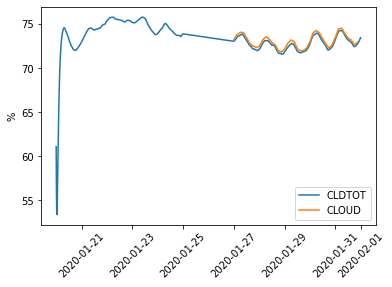

In [15]:
import sys
# Compare time series of CLDTOT, LIQ_MASK, ICE_MASK, CLD_MASK
variable_names = ('CLDTOT', 'CLOUD',)
output_path = '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127'
all_files = glob(f'{output_path}/*.eam.h[0-9].*.nc')
figure, ax = pyplot.subplots(1, 1) # figsize=(10, 10))
threshold = 0.5
for ivar, v in enumerate(variable_names):
    # find files
    print(v)
    print('  find files...'); sys.stdout.flush()
    these_files = [f for f in all_files if can_retrieve_field(f, v)]
    
    # Load files
    print('  load dataset...'); sys.stdout.flush()
    ds = open_dataset(sorted(these_files), chunks={'time': 1, 'lev': 1})
    
    # Get data
    print('  get data...'); sys.stdout.flush()
    data = get_data(ds, v)

    # Compute area mask
    if 'lev' in data.dims:
        data = data.max(dim='lev', keep_attrs=True)

    if v == 'CLOUD':
        attrs = data.attrs
        data = data > threshold
        data.attrs = attrs
        
    # Compute area averages
    print('  compute averages...'); sys.stdout.flush()
    w = get_area_weights(ds)
    m = area_average(data, w, dims=[d for d in data.dims if d != 'time'])
    
    # Convert units
    if data.attrs['units'] in ('fraction', 'none'):
        print('  convert units...'); sys.stdout.flush()
        m = 100.0 * m
        m.attrs['units'] = '%'
        
    # Plot timeseries
    print('  plot...'); sys.stdout.flush()
    pl = ax.plot(data.time, m, label=v)
    
    ds.close()
    
ax.set_ylabel(m.attrs['units'])
ax.xaxis.set_tick_params(rotation=45.0)
lh = pyplot.legend()

In [16]:
print('done')

done


In [17]:
figure.savefig('cloud_mask2.png', bbox_inches='tight')

  compute averages...
  convert units...
  plot...


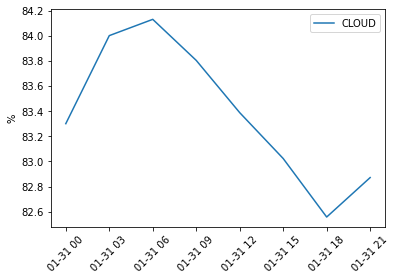

In [24]:
import sys

# Compare time series of CLDTOT, LIQ_MASK, ICE_MASK, CLD_MASK
variable_names = ('CLDTOT', 'RADCLD',)
output_path = '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201127'
all_files = glob(f'{output_path}/*.eam.h[0-9].2020-01-31-*.nc')
figure, ax = pyplot.subplots(1, 1) # figsize=(10, 10))
threshold = 0.0
    
# Get cloud fraction
cloud_files = [f for f in all_files if can_retrieve_field(f, 'CLOUD')]
ds_cloud = open_dataset(sorted(cloud_files), chunks={'time': 1, 'lev': 1})
cloud = get_data(ds_cloud, 'CLOUD')

# Get visible wavelength cloud optical depth
optics_files = [f for f in all_files if can_retrieve_field(f, 'EMIS')]
ds_optics = open_dataset(sorted(optics_files), chunks={'time': 1, 'lev': 1})
dtau_cld = get_data(ds_optics, 'EMIS')

# Get mean optical depth for each layer
#dtau = cloud * dtau_cld
dtau = dtau_cld

# Compute total column optical depth
tau = dtau.sum(dim='lev')

# Compute cloud mask based on optical depth threshold
cloud_mask = tau > threshold
cloud_mask.attrs = {
    'long_name': 'Cloud mask (tau > {threshold})',
    'units'    : 'none',
}
data = cloud_mask

# Compute area averages
print('  compute averages...'); sys.stdout.flush()
w = get_area_weights(ds_optics)
m = area_average(data, w, dims=[d for d in data.dims if d != 'time'])

# Convert units
if data.attrs['units'] in ('fraction', 'none'):
    print('  convert units...'); sys.stdout.flush()
    m = 100.0 * m
    m.attrs['units'] = '%'

# Plot timeseries
print('  plot...'); sys.stdout.flush()
pl = ax.plot(data.time, m, label=v)

ds_cloud.close()
ds_optics.close()

ax.set_ylabel(m.attrs['units'])
ax.xaxis.set_tick_params(rotation=45.0)
lh = pyplot.legend()

In [19]:
optics_files

[]